In [2]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow import keras
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler
from tensorflow.keras.regularizers import l2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import zipfile
import os
from sklearn.model_selection import train_test_split
from PIL import Image
import warnings
warnings.filterwarnings("ignore")

In [2]:
print(tf.__version__)

2.10.0


In [4]:
# Set directory path
data_dir = "/PROJECTS AND  STUFF/SNAKE_SPECIES_DETECTION/Dataset - Copy (2)"
# Sort class names numerically as labeling is in String form
classes = sorted(os.listdir(data_dir), key=lambda x: int(x))

# Collect all image paths and labels
image_paths = []
labels = []

for i, class_name in enumerate(classes):
    class_dir = os.path.join(data_dir, class_name)
    for img in os.listdir(class_dir):
        if img.lower().endswith(('.jpg', '.png', '.jpeg')):  # Ensure valid image files
            image_paths.append(os.path.join(class_dir, img))
            labels.append(i)  # Assign class index as integer

# Convert to numpy arrays
image_paths = np.array(image_paths)
labels = np.array(labels)

# Perform stratified split
train_paths, val_paths, train_labels, val_labels = train_test_split(
    image_paths, labels, test_size=0.2, stratify=labels, random_state=42
)

# Create datasets
def load_image(path, label):
    img = tf.io.read_file(path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.resize(img, (128, 128)) / 255.0  # Normalize
    return img, label

train_ds = tf.data.Dataset.from_tensor_slices((train_paths, train_labels))
train_ds = train_ds.map(load_image).batch(16)
train_ds = train_ds.shuffle(buffer_size=len(train_paths))

val_ds = tf.data.Dataset.from_tensor_slices((val_paths, val_labels))
val_ds = val_ds.map(load_image).batch(16) 

In [5]:
print(len(image_paths))

6515


In [6]:
print(classes)

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12']


In [7]:
print(f"Number of training batches: {len(train_ds)}")
print(f"Number of validation batches: {len(val_ds)}")

Number of training batches: 326
Number of validation batches: 82


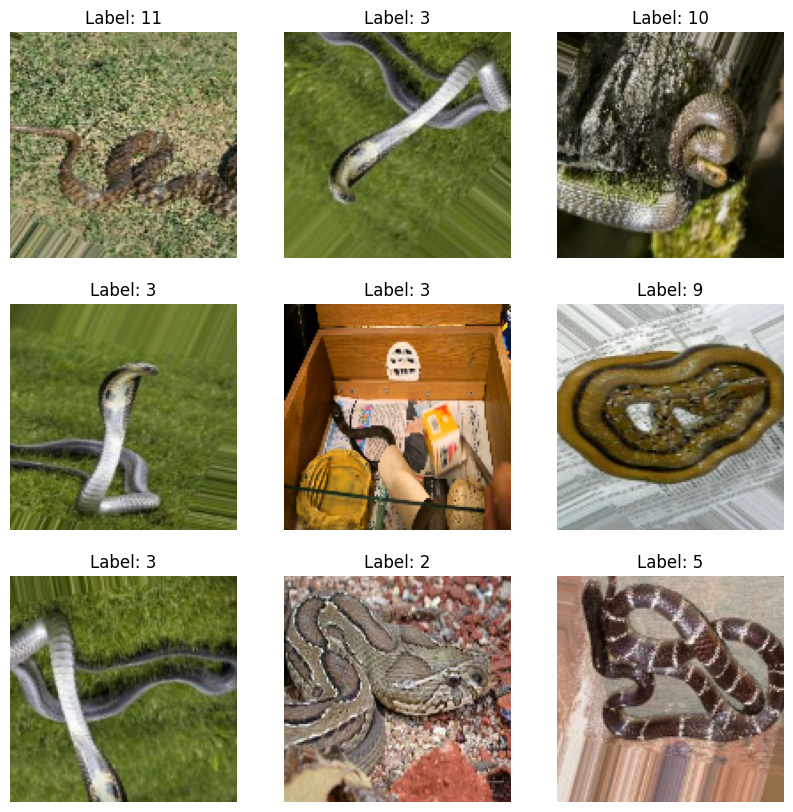

In [8]:
for images, labels in train_ds.take(1):  
    plt.figure(figsize=(10, 10))
    for i in range(9):  # Show 9 images
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy())
        plt.title(f"Label: {labels[i].numpy()}")
        plt.axis("off")
    plt.show()

Min pixel value: 0.0
Max pixel value: 1.0


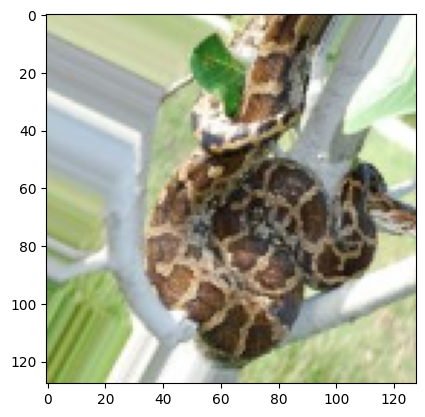

In [9]:
for image_batch, label_batch in train_ds.take(1):  # Get one batch of images
    image = image_batch[1].numpy()  # Take the first image of the batch
    print(f"Min pixel value: {np.min(image)}")
    print(f"Max pixel value: {np.max(image)}")
    
    # Plot the image to visually inspect it
    plt.imshow(image)
    plt.show()

In [10]:
# Transfer Learning
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(128, 128, 3),
    include_top=False,
    weights='imagenet'
)

base_model.trainable = False  # Freeze base layers
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(13, activation='softmax')
])

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_128 (Funct  (None, 4, 4, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 128)               163968    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 13)                1677      
                                                                 
Total params: 2,423,629
Trainable params: 165,645
Non-tr

In [12]:
from tensorflow.keras.optimizers.schedules import ExponentialDecay

lr_schedule = ExponentialDecay(
    initial_learning_rate=0.001, decay_steps=1000, decay_rate=0.9
)

In [13]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),loss='sparse_categorical_crossentropy',metrics=['accuracy'])

In [14]:
history = model.fit(train_ds,epochs=15,batch_size=32,validation_data=val_ds)

Epoch 1/15
326/326 [==============================] - 24s 25ms/step - loss: 0.6753 - accuracy: 0.7930 - val_loss: 0.4234 - val_accuracy: 0.8526
Epoch 2/15
326/326 [==============================] - 8s 17ms/step - loss: 0.3468 - accuracy: 0.8843 - val_loss: 0.3728 - val_accuracy: 0.8711
Epoch 3/15
326/326 [==============================] - 8s 17ms/step - loss: 0.2633 - accuracy: 0.9091 - val_loss: 0.3805 - val_accuracy: 0.8741
Epoch 4/15
326/326 [==============================] - 8s 16ms/step - loss: 0.2016 - accuracy: 0.9327 - val_loss: 0.3759 - val_accuracy: 0.8734
Epoch 5/15
326/326 [==============================] - 9s 19ms/step - loss: 0.1589 - accuracy: 0.9490 - val_loss: 0.3585 - val_accuracy: 0.8818
Epoch 6/15
326/326 [==============================] - 9s 16ms/step - loss: 0.1206 - accuracy: 0.9580 - val_loss: 0.3918 - val_accuracy: 0.8803
Epoch 7/15
326/326 [==============================] - 9s 18ms/step - loss: 0.1016 - accuracy: 0.9670 - val_loss: 0.4092 - val_accuracy: 0.879

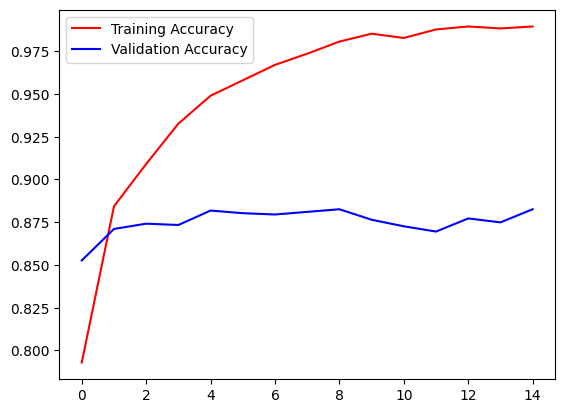

In [15]:
plt.plot(history.history['accuracy'],color='red',label='Training Accuracy')
plt.plot(history.history['val_accuracy'],color='blue',label='Validation Accuracy')
plt.legend()
plt.show() 

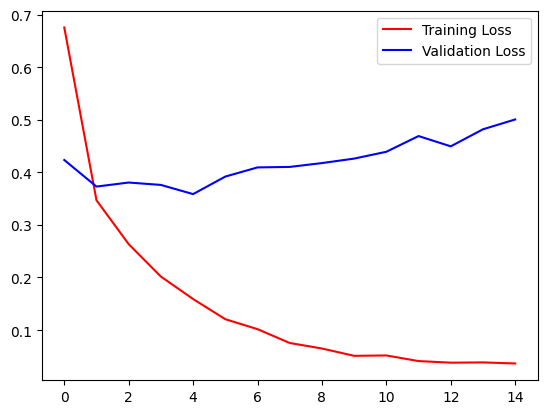

In [16]:
plt.plot(history.history['loss'],color='red',label='Training Loss')
plt.plot(history.history['val_loss'],color='blue',label='Validation Loss')
plt.legend()
plt.show()

In [17]:
model.save("snake_classification.h5", save_format="h5")

In [18]:
loaded_model_hs = tf.keras.models.load_model("snake_classification.h5")

In [19]:
loaded_model_hs.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_128 (Funct  (None, 4, 4, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 128)               163968    
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 13)                1677      
                                                                 
Total params: 2,423,629
Trainable params: 165,645
Non-tr

In [20]:
# Load and preprocess the image
def preprocess_image(image_path, target_size=(128, 128)):  
    img = Image.open(image_path).convert("RGB")  
    img = img.resize(target_size)  
    img_array = np.array(img) / 255.0  
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

# Path to test image
image_path = "9.jpg"  # Change to your image path

# Preprocess and predict
input_image = preprocess_image(image_path)

prediction = loaded_model_hs.predict(input_image)
softmax_probs = tf.nn.softmax(prediction)

# Get the predicted class -> Maximum Probability in softmax_probs
predicted_class = tf.argmax(softmax_probs,axis=-1).numpy()

print(f"Predicted Class: {predicted_class}")

df = pd.read_csv("Snake_Species.csv")

snake_labels = list(df['Index '].values)
snake_name = list(df['Snake'].values)

for i,label in enumerate(snake_labels):
    if label == predicted_class[0]:
        print(f"Snake is - {snake_name[i]}")

1/1 [==============================] - 1s 1s/step
Predicted Class: [9]
Snake is - Common Trinket


In [21]:
model.save("snake_classification_model", save_format="tf")

INFO:tensorflow:Assets written to: snake_classification_model\assets


INFO:tensorflow:Assets written to: snake_classification_model\assets


In [ ]:
model.save("snake_classification.keras")